In [1]:
#3D Version
from mpi4py import MPI
import gmsh
from dolfinx.io import gmsh as gmshio
from dolfinx import mesh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# 1) Load MRST data (Pa) with header x,y,pressure
# data = np.loadtxt("pressure_field_lagrange_example1.csv", delimiter=",", skiprows=1)
# x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))

comm = MPI.COMM_WORLD
rank = comm.rank

x_start, y_start = 0.25, 0.01
x_end, y_end = 0.75, 0.99

N_ref = 8


In [ ]:
#MESH GENERATION
for ref in range(N_ref+1):
    # --- user params ---
    h   = 1/(2**(ref+1))    # target size for Ω
    h_g = h/2   # target size for Γ

    gmsh.initialize()

    # ---------- Build Ω: structured quads via Gmsh ----------
    n_float = 1.0 / h
    n = int(round(n_float))
    if abs(n_float - n) > 1e-12:
        raise ValueError("For a regular Cartesian grid, choose h = 1/n (so 1/h must be an integer).")
    gmsh.model.add("Omega")

    # --- Base 2D geometry (z = 0 plane) ---
    p1 = gmsh.model.occ.addPoint(0, 0, 0)
    p2 = gmsh.model.occ.addPoint(1, 0, 0)
    p3 = gmsh.model.occ.addPoint(1, 1, 0)
    p4 = gmsh.model.occ.addPoint(0, 1, 0)

    l1 = gmsh.model.occ.addLine(p1, p2)
    l2 = gmsh.model.occ.addLine(p2, p3)
    l3 = gmsh.model.occ.addLine(p3, p4)
    l4 = gmsh.model.occ.addLine(p4, p1)
    cl = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
    surf = gmsh.model.occ.addPlaneSurface([cl])
    gmsh.model.occ.synchronize()

    # --- Structured 2D mesh controls before extrusion ---
    gmsh.model.mesh.setTransfiniteCurve(l1, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l2, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l3, n + 1)
    gmsh.model.mesh.setTransfiniteCurve(l4, n + 1)
    gmsh.model.mesh.setTransfiniteSurface(surf)
    gmsh.model.mesh.setRecombine(2, surf)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)

    # --- Extrude into a thin 3D slab ---
    out = gmsh.model.occ.extrude([(2, surf)], 0, 0, 0.02, numElements=[1], recombine=True)
    gmsh.model.occ.synchronize()

    # --- Define physical group for volume (dim=3) ---
    vols = [ent[1] for ent in gmsh.model.getEntities(dim=3)]
    pg_omega = gmsh.model.addPhysicalGroup(3, vols)
    gmsh.model.setPhysicalName(3, pg_omega, "Omega")

    # Optional: define boundary groups if needed
    # walls = [ent[1] for ent in gmsh.model.getEntities(dim=2)]
    # gmsh.model.addPhysicalGroup(2, walls)

    # --- Generate mesh ---
    gmsh.model.mesh.generate(3)
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.model_to_mesh(
        gmsh.model, comm, rank, gdim=3
    )[0:3]

    # --- Save Ω mesh before clearing ---
    if rank == 0:
        filename = f"Omega_ex1_{ref}.msh"
        gmsh.write(filename)

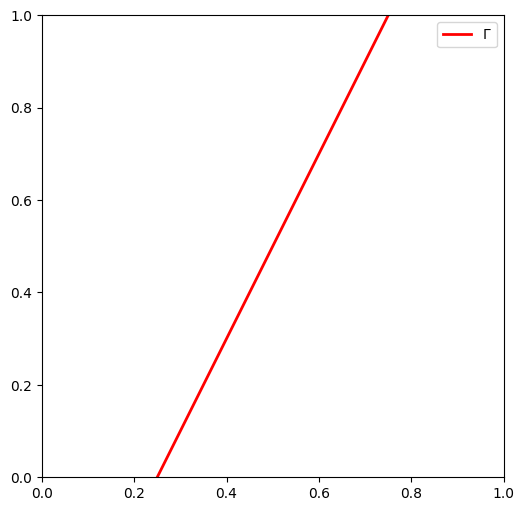

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Plot fracture γ
ax.plot([x_start, x_end], [y_start-0.01, y_end+0.01],
        'r-', linewidth=2, label=r"$\Gamma$")

# Set exact domain bounds
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', adjustable='box')  # force square axes

# Label and title
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title(r"Domain $\Omega$ with fracture $\gamma$.")

# Disable autoscaling AFTER setting limits (prevents expansion)
ax.set_autoscale_on(False)

# Add legend last
ax.legend()

plt.show()

In [2]:
# APPROXIMATING EXACT SOLUTION
from dolfinx import mesh, fem
import ufl
import numpy as np
# from dolfinx.cpp.mesh import compute_cell_sizes

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
N_ref = 7
ref = N_ref
filename = f"Omega_ex1_{ref}.msh"
Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
# Compute cell diameters (length of the longest edge in each cell)
# all_h = compute_cell_sizes(Omega, "max")

# For example, get average or min/max
# h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

coords = Omega.geometry.x
hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
h = min(hx, hy)
# Clear gmsh model before building Γ
# gmsh.clear()

# ================= Γ: line (1D embedded in 3D plane z=0) =================
gmsh.initialize()
h_g = h/2
gmsh.model.add("Gamma")
p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
line = gmsh.model.occ.addLine(p0, p1)
gmsh.model.occ.synchronize()

gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
gmsh.model.mesh.generate(1)

# Import Gamma mesh, embed in 3D (gdim=3)
Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(gmsh.model, comm, rank, gdim=3)[0:3]

gmsh.finalize()

order = 2
V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
p_m, p_f, lmbd = ufl.TrialFunctions(W)

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(Omega)
f_m = fem.Constant(Omega, 0.0)
f_f = fem.Constant(Gamma, 0.0)

# k_m = fem.Constant(Omega, 1.0)
# Diagonal entries
k_values = np.array([[1.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])

# Define as a constant tensor field over Omega
k_m = fem.Constant(Omega, k_values)
k_f = fem.Constant(Gamma, 10.0)

dx = ufl.Measure("dx", domain=Omega)
ds = ufl.Measure("dx", domain=Gamma)
# Boundary measure on ∂Omega (outer boundary)
ds_Omega = ufl.Measure("ds", domain=Omega)

# Compute bounding box to locate sides
coords = Omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]

xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Neumann data g_N = k_m grad(p_m)·n on ∂Omega
# Top (y = ymax):    u·n = -1 -> g_N =  1
# Bottom (y = ymin): u·n =  2 -> g_N = -2
g_N = ufl.conditional(
    ufl.lt(abs(x[1] - ymax), tol),
    fem.Constant(Omega, -1.0),
    ufl.conditional(
        ufl.lt(abs(x[1] - ymin), tol),
        fem.Constant(Omega, 2.0),
        fem.Constant(Omega, 0.0),
    ),
)

# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------
# --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
from fenicsx_ii import Average, Circle
import basix.ufl
R = np.min([0.0001, h/4])        # tube/circle radius around Γ (tune as you like)
q_degree = 16   # quadrature degree along the circle (tune)

# Restriction operators for trial and test sides
restriction_trial = Circle(Gamma, R, degree=q_degree, )
restriction_test  = Circle(Gamma, R, degree=q_degree)

# Quadrature space on Γ used to represent the averages
q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
Rs   = fem.functionspace(Gamma, q_el)

# Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# a_m1 = -lmbd * phi * ds
a_m1 = - lmbd * avg_phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx
L_m -= g_N * phi * ds_Omega  # <-- NEW: Neumann BC on top/bottom

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# a_l0 = p_m * mu * ds
a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(Gamma, 0.0) * mu * ds

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
# all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
# p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 1.0
p_m_bc.x.array[right_dofs]  = 4.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

# tolerance scaled to Γ
tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

# locate dofs at each tip
tip1_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                             np.isclose(x[1], y_start, atol=tol_g))
)
tip2_dofs = fem.locate_dofs_geometrical(
    V_f,
    lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                             np.isclose(x[1], y_end, atol=tol_g))
)
# OR (ii) Different values at the two tips -> two BC objects
both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

# one Function-valued BC with piecewise values
pf_fun = fem.Function(V_f)
# pf_fun.x.array[:] = 0.0
pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

bc_pf = fem.dirichletbc(pf_fun, both_tips)

# add it
bcs = [bc_pm, bc_pf]

a = a_m + a_gamma
L = L_m + L_gamma

from fenicsx_ii import LinearProblem, assemble_scalar
petsc_options = {
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "ksp_error_if_not_converged": True,
}
problem = LinearProblem(
    a,
    L,
    petsc_options_prefix="coupled_poisson",
    petsc_options=petsc_options,
    bcs=bcs,
)
p_m, p_f, lmbd = problem.solve()
p_m.name = "p_m"
p_f.name = "p_f"
lmbd.name = "lmbd"

p_m_exact = p_m
p_f_exact = p_f
lmbd_exact = lmbd

Info    : Reading 'Omega_ex1_7.msh'...
Info    : 27 entities
Info    : 132098 nodes
Info    : 65536 elements                                                                                      
Info    : Done reading 'Omega_ex1_7.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000453007s, CPU 0.000953s)
Info    : 565 nodes 566 elements


In [ ]:
from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_case4_new")
outdir.mkdir(exist_ok=True)

from dolfinx.io import XDMFFile

# ------------------------------
# 1) Save bulk field p_m on Ω
# ------------------------------
omega_file = outdir / "omega_finest.xdmf"
with XDMFFile(Omega.comm, str(omega_file), "w") as xdmf:
    xdmf.write_mesh(Omega)
    xdmf.write_function(p_m_exact)

# ------------------------------
# 2) Save interface fields p_f, λ on Γ
# ------------------------------
gamma_file = outdir / "gamma_finest.xdmf"
with XDMFFile(Gamma.comm, str(gamma_file), "w") as xdmf:
    xdmf.write_mesh(Gamma)
    xdmf.write_function(p_f_exact)
    xdmf.write_function(lmbd_exact)

RuntimeError: Degree of output Function must be same as mesh degree. Maybe the Function needs to be interpolated?

Info    : Reading 'Omega_ex1_0.msh'...
Info    : 27 entities
Info    : 18 nodes
Info    : 4 elements
Info    : Done reading 'Omega_ex1_0.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 6.7096e-05s, CPU 9.3e-05s)
Info    : 6 nodes 7 elements
global min:  [0. 0. 0.]
global max:  [1.   1.   0.02]
global min:  [0.25 0.01 0.01]
global max:  [0.75 0.99 0.01]
global min:  [0.25 0.01 0.01]
global max:  [0.75 0.99 0.01]
Info    : Reading 'Omega_ex1_1.msh'...
Info    : 27 entities
Info    : 50 nodes
Info    : 16 elements
Info    : Done reading 'Omega_ex1_1.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000106378s, CPU 0.000122s)
Info    : 10 nodes 11 elements
global min:  [0. 0. 0.]
global max:  [1.   1.   0.02]
global min:  [0.25 0.01 0.01]
global max:  [0.75 0.99 0.01]
global min:  [0.25 0.01 0.01]
global max:  [0.75 0.99 0.01]
Info    : Reading 'Omega_ex1_2.msh'...
Info    : 27 entities
Info    : 16

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


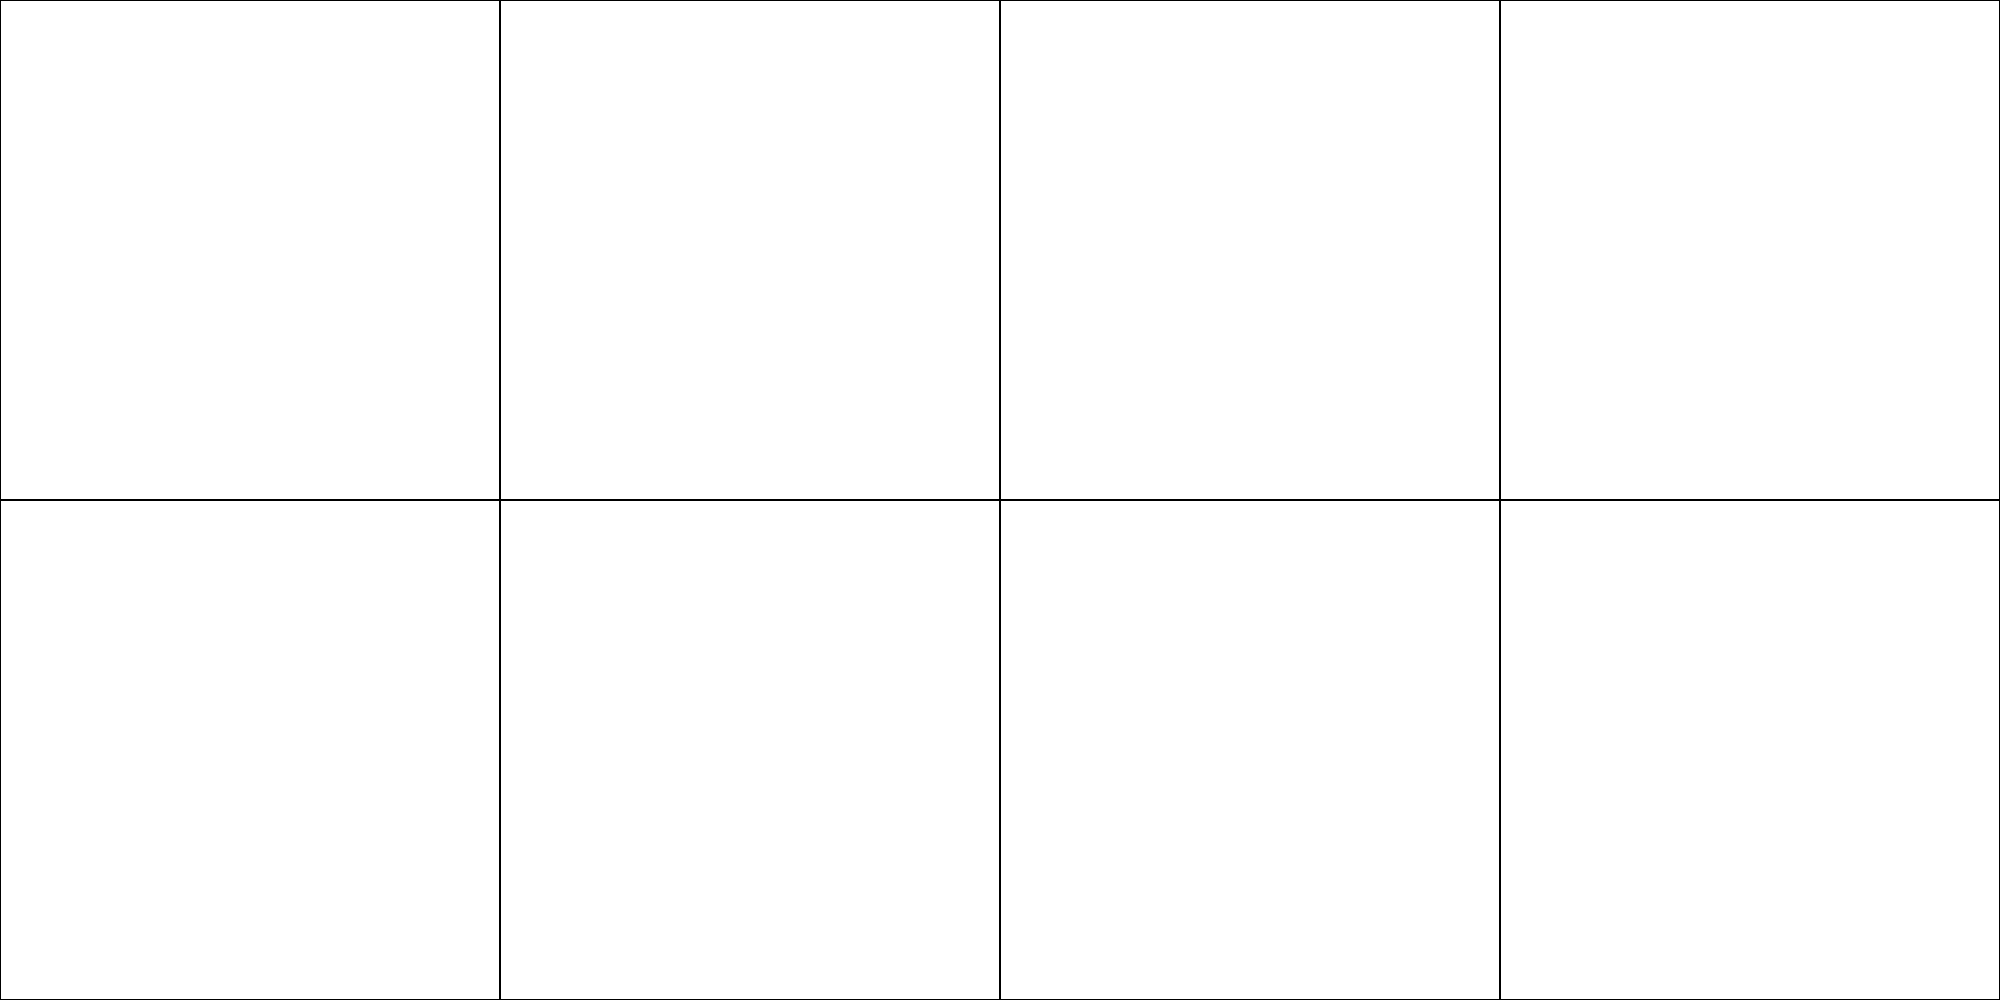

In [3]:
from dolfinx import geometry
def l2_h1_errors(p, p_exact, comm=MPI.COMM_WORLD):
    import numpy as np
    import ufl
    from dolfinx.mesh import locate_entities_boundary

    mesh_fine = p_exact.function_space.mesh
    mesh_coarse = p.function_space.mesh

    tdim = mesh_fine.topology.dim

    # --- Trees on the COARSE mesh (we will evaluate p on the coarse mesh) ---
    bbt_coarse = geometry.bb_tree(mesh_coarse, tdim)
    mid_tree_coarse = geometry.create_midpoint_tree(
        mesh_coarse, tdim,
        np.arange(mesh_coarse.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # --- Allocate target on the FINE space: p_coarse sampled at fine DoF points ---
    p_coarse_on_exact = fem.Function(p_exact.function_space)

    def eval_p_coarse_on_points(x: np.ndarray) -> np.ndarray:
        gdim, N = x.shape
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # 1) candidates on COARSE mesh
        cands = geometry.compute_collisions_points(bbt_coarse, X3)
        # 2) filter to true hits
        hits = geometry.compute_colliding_cells(mesh_coarse, cands, X3)

        # 3) pick one owning cell per point
        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # Fallback: nearest coarse cell by midpoint
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(
                bbt_coarse, mid_tree_coarse, mesh_coarse, X3[missing]
            )
            cells[missing] = nearest

        # 4) evaluate coarse solution p at those points/cells
        vals_1d = p.eval(X3, cells)  # (N,)
        return np.asarray(vals_1d, dtype=np.float64).reshape(1, N)  # scalar -> (1, N)

    # Interpolate coarse solution into fine space
    p_coarse_on_exact.interpolate(eval_p_coarse_on_points)

    # ---------------------------------------------------------------------
    # NEW (minimal): build a DG0 mask on the FINE mesh that is 1 for interior cells
    # and 0 for cells that touch the exterior boundary facets.
    # ---------------------------------------------------------------------
    # marker returning True for all facet points => whole exterior
    # is_on_boundary = lambda x: np.ones(x.shape[1], dtype=bool)
    comm = mesh_fine.comm
    gdim = mesh_fine.geometry.dim

    # compute local mins/maxs
    coords = mesh_fine.geometry.x  # (num_local_vertices, gdim)
    local_min = np.min(coords, axis=0)
    local_max = np.max(coords, axis=0)

    # correct global reduction (returns arrays)
    global_min = comm.allreduce(local_min, op=MPI.MIN)
    global_max = comm.allreduce(local_max, op=MPI.MAX)
    # print('global min: ', global_min)
    # print('global max: ', global_max)

    # choose tol small compared to h (your h=1/512 ~2e-3)
    tol = 1e-12  # tiny absolute tolerance (or use tol = 1e-6 * h)

    def is_on_boundary(x: np.ndarray) -> np.ndarray:
        # x: (gdim, npoints)
        pts = x.T  # shape (npoints, gdim)
        on_min = np.any(np.isclose(pts, global_min, atol=tol), axis=1)
        on_max = np.any(np.isclose(pts, global_max, atol=tol), axis=1)
        return (on_min | on_max)
    
    def is_on_xy_boundary(x: np.ndarray) -> np.ndarray:
        """
        x: shape (gdim, npoints)
        Return True for points lying on x==min_x, x==max_x, y==min_y, or y==max_y (within tol).
        Ignores z coordinate completely.
        """
        pts = x.T  # (npoints, gdim)
        # compare only x and y columns (0 and 1)
        on_xmin = np.isclose(pts[:, 0], global_min[0], atol=tol)
        on_xmax = np.isclose(pts[:, 0], global_max[0], atol=tol)
        on_ymin = np.isclose(pts[:, 1], global_min[1], atol=tol)
        on_ymax = np.isclose(pts[:, 1], global_max[1], atol=tol)
        return (on_xmin | on_xmax | on_ymin | on_ymax)

    if gdim == 3:
    # 2) find facets whose sample points lie on x/y bounding planes
        boundary_facets_fine = locate_entities_boundary(mesh_fine, tdim - 1, is_on_xy_boundary)
    else:
        boundary_facets_fine = locate_entities_boundary(mesh_fine, tdim - 1, is_on_boundary)

    # ensure facet->cell connectivity and get adjacent cells
    mesh_fine.topology.create_connectivity(tdim - 1, tdim)
    facet_to_cell_fine = mesh_fine.topology.connectivity(tdim - 1, tdim)

    if boundary_facets_fine.size > 0:
        boundary_cells_fine = np.unique(np.hstack([facet_to_cell_fine.links(f) for f in boundary_facets_fine]))
    else:
        boundary_cells_fine = np.array([], dtype=np.int32)

    # number of local fine cells and DG0 marker values
    num_cells_fine = mesh_fine.topology.index_map(tdim).size_local
    chi_vals = np.ones(num_cells_fine, dtype=np.float64)
    chi_vals[boundary_cells_fine] = 0.0

    # create chi_fine as DG0 function on the fine mesh
    V0_fine = fem.functionspace(mesh_fine, ("DG", 0))
    chi_fine = fem.Function(V0_fine)
    chi_fine.x.array[:] = chi_vals
    
    # print("total cells (global):", comm.allreduce(num_cells_fine, op=MPI.SUM))
    # print("total interior cells (global):", comm.allreduce(np.sum(chi_vals), op=MPI.SUM))

    # ---------------------------------------------------------------------

    # --- Integrate on the FINE mesh/domain (but exclude boundary-touching cells using chi_fine) ---
    dx = ufl.dx(domain=mesh_fine)
    err = p_exact - p_coarse_on_exact

    # ||err||_L2^2, excluding boundary-touching cells
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * chi_fine * dx))
    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)

    # |err|_H1^2 = ||∇err||_L2^2, excluding boundary-touching cells
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * chi_fine * dx))
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    # Norms
    err_L2 = np.sqrt(L2_sq)
    err_H1_semi = np.sqrt(H1_semi_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # --- relative errors ---
    # ||p_exact||_L2^2 (excluding boundary-touching cells)
    L2_exact_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_coarse_on_exact, p_coarse_on_exact) * chi_fine * dx))
    L2_exact_sq = comm.allreduce(L2_exact_sq_local, op=MPI.SUM)

    # |p_exact|_H1^2 (excluding boundary-touching cells)
    H1_semi_exact_sq_local = fem.assemble_scalar(
        fem.form(ufl.inner(ufl.grad(p_coarse_on_exact), ufl.grad(p_coarse_on_exact)) * chi_fine * dx)
    )
    H1_semi_exact_sq = comm.allreduce(H1_semi_exact_sq_local, op=MPI.SUM)

    # Norms of exact
    exact_L2 = np.sqrt(L2_exact_sq)
    exact_H1_semi = np.sqrt(H1_semi_exact_sq)
    exact_H1_full = np.sqrt(L2_exact_sq + H1_semi_exact_sq)

    # Relative errors with zero-denominator guard
    rel_L2 = err_L2 / exact_L2 if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_semi = err_H1_semi / exact_H1_semi if exact_H1_semi > 0 else (0.0 if err_H1_semi == 0 else np.inf)
    rel_H1_full = err_H1_full / exact_H1_full if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return {
        "err_L2": err_L2,
        "err_H1_semi": err_H1_semi,
        "err_H1_full": err_H1_full,
        "rel_L2": rel_L2,
        "rel_H1_semi": rel_H1_semi,
        "rel_H1_full": rel_H1_full
    }
    # return err_L2, err_H1_full

from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_nonconforming")
outdir.mkdir(exist_ok=True)
for ref in range(N_ref):
    filename = f"Omega_ex1_{ref}.msh"
    Omega, cell_tags_Omega, facet_tags_Omega = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=3)[0:3]
    tdim = Omega.topology.dim  # 2
    # fdim = 1             # 1
    # Compute cell diameters (length of the longest edge in each cell)
    # all_h = compute_cell_sizes(Omega, "max")

    # For example, get average or min/max
    # h = Omega.comm.allreduce(np.median(h.array), op=MPI.SUM) / Omega.comm.size

    coords = Omega.geometry.x
    hx = np.min(np.diff(np.unique(np.sort(coords[:,0]))))
    hy = np.min(np.diff(np.unique(np.sort(coords[:,1]))))
    h = min(hx, hy)
    # Clear gmsh model before building Γ
    # gmsh.clear()

    # ================= Γ: line (1D embedded in 3D plane z=0) =================
    gmsh.initialize()
    h_g = h/2
    gmsh.model.add("Gamma")
    p0 = gmsh.model.occ.addPoint(x_start, y_start, 0.01)
    p1 = gmsh.model.occ.addPoint(x_end, y_end, 0.01)
    line = gmsh.model.occ.addLine(p0, p1)
    gmsh.model.occ.synchronize()

    gmsh.model.mesh.setSize([(0, p0), (0, p1)], h_g)
    pg_gamma = gmsh.model.addPhysicalGroup(1, [line])
    gmsh.model.setPhysicalName(1, pg_gamma, "Gamma")
    gmsh.model.mesh.generate(1)

    # Import Gamma mesh, embed in 3D (gdim=3)
    Gamma, cell_tags_Gamma, facet_tags_Gamma = gmshio.model_to_mesh(gmsh.model, comm, rank, gdim=3)[0:3]

    gmsh.finalize()

    order = 2
    V_m = fem.functionspace(Omega, ("Lagrange", order))  # bulk Ω
    V_f = fem.functionspace(Gamma, ("Lagrange", order))   # interface Γ
    V_l = fem.functionspace(Gamma, ("Lagrange", order))   # multiplier space on Γ
    W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

    # ---------------------------------------------------------------------
    # 3. Trial and Test functions
    # ---------------------------------------------------------------------
    phi, psi, mu = ufl.TestFunctions(W)
    p_m, p_f, lmbd = ufl.TrialFunctions(W)

    # ---------------------------------------------------------------------
    # 4. Spatial coordinates and given data
    # ---------------------------------------------------------------------
    x = ufl.SpatialCoordinate(Omega)
    f_m = fem.Constant(Omega, 0.0)
    f_f = fem.Constant(Gamma, 0.0)

    # k_m = fem.Constant(Omega, 1.0)
    # Diagonal entries
    k_values = np.array([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0]])

    # Define as a constant tensor field over Omega
    k_m = fem.Constant(Omega, k_values)
    k_f = fem.Constant(Gamma, 10.0)

    dx = ufl.Measure("dx", domain=Omega)
    ds = ufl.Measure("dx", domain=Gamma)
    # Boundary measure on ∂Omega (outer boundary)
    ds_Omega = ufl.Measure("ds", domain=Omega)

    # Compute bounding box to locate sides
    coords = Omega.geometry.x
    xx = coords[:, 0]
    yy = coords[:, 1]

    xmin, xmax = xx.min(), xx.max()
    ymin, ymax = yy.min(), yy.max()

    # Tolerance for side detection
    tol = 1e-10 * max(xmax - xmin, ymax - ymin)

    # Neumann data g_N = k_m grad(p_m)·n on ∂Omega
    # Top (y = ymax):    u·n = -1 -> g_N =  1
    # Bottom (y = ymin): u·n =  2 -> g_N = -2
    g_N = ufl.conditional(
        ufl.lt(abs(x[1] - ymax), tol),
        fem.Constant(Omega, -1.0),
        ufl.conditional(
            ufl.lt(abs(x[1] - ymin), tol),
            fem.Constant(Omega, 2.0),
            fem.Constant(Omega, 0.0),
        ),
    )

    # ---------------------------------------------------------------------
    # 5. Weak formulations
    # ---------------------------------------------------------------------
    # --- Averaged trace operators for bulk functions on Γ (fenicsx_ii) ---
    from fenicsx_ii import Average, Circle
    import basix.ufl
    R = np.min([0.0001, h/4])        # tube/circle radius around Γ (tune as you like)
    q_degree = 16   # quadrature degree along the circle (tune)

    # Restriction operators for trial and test sides
    restriction_trial = Circle(Gamma, R, degree=q_degree, )
    restriction_test  = Circle(Gamma, R, degree=q_degree)

    # Quadrature space on Γ used to represent the averages
    q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
    Rs   = fem.functionspace(Gamma, q_el)

    # Averages for the *bulk* unknown and *bulk* test, to be used only on integrals over Γ
    avg_pm  = Average(p_m,  restriction_trial, Rs)  # Π_R(p_m) on Γ
    avg_phi = Average(phi, restriction_test,  Rs)   # Π_R(φ)   on Γ

    # --- Bulk domain Ω ---------------------------------------------------
    a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
    # a_m1 = -lmbd * phi * ds
    a_m1 = - lmbd * avg_phi * ds
    a_m = a_m0 + a_m1
    L_m = f_m * phi * dx
    L_m -= g_N * phi * ds_Omega  # <-- NEW: Neumann BC on top/bottom

    # --- Interface Γ -----------------------------------------------------
    a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
    a_f1 = lmbd * psi * ds
    a_f = a_f0 + a_f1
    L_f = f_f * psi * ds

    # --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
    # a_l0 = p_m * mu * ds
    a_l0 =  avg_pm * mu * ds          # <-- use averaged bulk unknown on Γ
    a_l1 = -p_f * mu * ds
    a_l = a_l0 + a_l1
    L_l = fem.Constant(Gamma, 0.0) * mu * ds

    # ---------------------------------------------------------------------
    # 6. Combine interface weak form
    # ---------------------------------------------------------------------
    a_gamma = a_f + a_l
    L_gamma = L_f + L_l

    F = a_m - L_m + a_gamma - L_gamma
    residual = ufl.extract_blocks(F)

    # Locate dofs on each side
    left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
    right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
    bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
    top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

    # Union of all boundary dofs for which we enforce a value
    # all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
    all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

    # Build a Function-valued BC so we can assign side-dependent values
    p_m_bc = fem.Function(V_m)
    # p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
    p_m_bc.x.array[left_dofs] = 1.0
    p_m_bc.x.array[right_dofs]  = 4.0

    # One BC object over the union of dofs with piecewise values
    bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

    # tolerance scaled to Γ
    tol_g = 1e-10 * np.max(np.ptp(Gamma.geometry.x, axis=0))

    # locate dofs at each tip
    tip1_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                                np.isclose(x[1], y_start, atol=tol_g))
    )
    tip2_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                                np.isclose(x[1], y_end, atol=tol_g))
    )
    # OR (ii) Different values at the two tips -> two BC objects
    both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

    # one Function-valued BC with piecewise values
    pf_fun = fem.Function(V_f)
    # pf_fun.x.array[:] = 0.0
    pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
    pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

    bc_pf = fem.dirichletbc(pf_fun, both_tips)

    # add it
    bcs = [bc_pm, bc_pf]

    a = a_m + a_gamma
    L = L_m + L_gamma

    from fenicsx_ii import LinearProblem, assemble_scalar
    petsc_options = {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    }
    problem = LinearProblem(
        a,
        L,
        petsc_options_prefix="coupled_poisson",
        petsc_options=petsc_options,
        bcs=bcs,
    )
    p_m, p_f, lmbd = problem.solve()
    p_m.name = "p_m"
    p_f.name = "p_f"
    lmbd.name = "lmbd"

    from dolfinx.io import XDMFFile

    # ------------------------------
    # 1) Save bulk field p_m on Ω
    # ------------------------------
    # omega_file = outdir / f"omega_ref{ref}.xdmf"
    # with XDMFFile(Omega.comm, str(omega_file), "w") as xdmf:
    #     xdmf.write_mesh(Omega)
    #     xdmf.write_function(p_m)

    # # ------------------------------
    # # 2) Save interface fields p_f, λ on Γ
    # # ------------------------------
    # gamma_file = outdir / f"gamma_ref{ref}.xdmf"
    # with XDMFFile(Gamma.comm, str(gamma_file), "w") as xdmf:
    #     xdmf.write_mesh(Gamma)
    #     xdmf.write_function(p_f)
    #     xdmf.write_function(lmbd)

    err_dict = l2_h1_errors(p_m, p_m_exact)
    err_dict_pf = l2_h1_errors(p_f, p_f_exact)
    err_dict_lmbd = l2_h1_errors(lmbd, lmbd_exact)
    err_L2_fem, err_H1_fem, rel_L2_fem, rel_H1_full_fem = err_dict["err_L2"], err_dict["err_H1_semi"], err_dict["rel_L2"], err_dict["rel_H1_semi"]
    err_L2_fem_pf, err_H1_fem_pf, rel_L2_fem_pf, rel_H1_full_fem_pf = err_dict_pf["err_L2"], err_dict_pf["err_H1_semi"], err_dict_pf["rel_L2"], err_dict_pf["rel_H1_semi"]
    err_L2_fem_lmbd, err_H1_fem_lmbd, rel_L2_fem_lmbd, rel_H1_full_fem_lmbd = err_dict_lmbd["err_L2"], err_dict_lmbd["err_H1_semi"], err_dict_lmbd["rel_L2"], err_dict_lmbd["rel_H1_semi"]

    # thickness = 0.02          # same value you extruded with
    # z_mid = 0 / 2.0   # center of the slab
    # # --- Mesh & spaces ---
    # mesh_c = p_m.function_space.mesh           # COARSE mesh
    # mesh_f = p_m_exact.function_space.mesh     # FINE mesh
    # tdim_c = mesh_c.topology.dim
    # tdim_f = mesh_f.topology.dim
    # gdim = mesh_f.geometry.dim
    # mesh_f.topology.create_connectivity(tdim_f, 0)  # cell -> vertex (you likely already had this)
    # mesh_f.topology.create_connectivity(0, tdim_f)  # vertex -> cell (REQUIRED for locate_dofs_topological)

    # # --- 0) get fine dof coordinates as evaluation points ---
    # V_f = p_m_exact.function_space
    # X_f = V_f.tabulate_dof_coordinates().reshape(-1, gdim)   # (Nf, gdim)
    # Nf = X_f.shape[0]

    # if gdim == 2:
    #     X3_f = np.column_stack([X_f, np.zeros(Nf, dtype=np.float64)])  # (Nf, 3)
    # elif gdim == 3:
    #     X3_f = X_f.copy()                                              # (Nf, 3)
    # else:
    #     raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # # --- 1) build tree on the COARSE mesh (where p_m lives) ---
    # bbt_c = geometry.bb_tree(mesh_c, tdim_c)
    # cands = geometry.compute_collisions_points(bbt_c, X3_f)
    # hits = geometry.compute_colliding_cells(mesh_c, cands, X3_f)

    # cells = np.full(Nf, -1, dtype=np.int32)
    # for i in range(Nf):
    #     li = hits.links(i)
    #     if len(li) > 0:
    #         cells[i] = li[0]

    # # robust fallback for any misses (-1), e.g. points on boundaries/tiny roundoff
    # missing = np.where(cells == -1)[0]
    # if missing.size:
    #     mid_tree_c = geometry.create_midpoint_tree(
    #         mesh_c, tdim_c,
    #         np.arange(mesh_c.topology.index_map(tdim_c).size_local, dtype=np.int32)
    #     )
    #     nearest = geometry.compute_closest_entity(bbt_c, mid_tree_c, mesh_c, X3_f[missing])
    #     cells[missing] = nearest

    # # --- 2) evaluate p_m (COARSE solution) at those FINE-space coordinates ---
    # p_coarse_on_finepts = p_m.eval(X3_f, cells).ravel()

    # # --- 3) grab the "exact" values at their own fine dofs ---
    # # (for standard Lagrange/nodal spaces, coefficient = nodal value)
    # p_exact_vals = p_m_exact.x.array.copy().ravel()

    # # 4) build plotting arrays (no error norms here)
    # x = X_f[:, 0].ravel()
    # y = X_f[:, 1].ravel()
    # diff_abs = np.abs(p_exact_vals - p_coarse_on_finepts)

    # # triangulation in the (x, y) plane
    # import matplotlib.tri as mtri
    # import matplotlib.pyplot as plt
    
    # tri = mtri.Triangulation(x, y)

    # V_c = p_m.function_space
    # # mesh_c = V_c.mesh
    # gdim_c = mesh_c.geometry.dim

    # # --- 1) Get coordinates ---
    # X_c = V_c.tabulate_dof_coordinates().reshape(-1, gdim_c)

    # # --- 2) Reduce to 2D by taking a slice if needed ---
    # if gdim_c == 2:
    #     X2 = X_c[:, :2]
    # elif gdim_c == 3:
    #     z = X_c[:, 2]
    #     z0 = z.min()
    #     mask = np.isclose(z, z0, atol=1e-10)
    #     X2 = X_c[mask, :2]      # x, y only
    # else:
    #     raise ValueError("Unsupported geometric dimension")

    # # --- 3) Extract unique grid lines ---
    # xc = np.unique(X2[:, 0])   # x grid lines
    # yc = np.unique(X2[:, 1])   # y grid lines

    # # common color range taken from both fields
    # vmin = float(min(np.nanmin(p_exact_vals), np.nanmin(p_coarse_on_finepts)))
    # vmax = float(max(np.nanmax(p_exact_vals), np.nanmax(p_coarse_on_finepts)))

    # # --- PyVista rendering of p_m on its mesh (as you had) ---
    # # topo2, ctype2, geom2 = plot.vtk_mesh(p_m.function_space)
    # # grid_2d = pv.UnstructuredGrid(topo2, ctype2, geom2)
    # # grid_2d.point_data["p_m"] = p_m.x.array.real

    # # optional: a segment to overlay (keep your existing endpoints)
    # # x_start, x_end, y_start, y_end must exist if you want the line shown
    # have_line = all(name in globals() for name in ["x_start","x_end","y_start","y_end"])

    # fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
    # fig.suptitle(f"h={h:.4f}", fontsize=16, y=1.02)  # keep your h variable

    # # axes[0].triplot(tri_c, linewidth=0.5)
    # # --- 4) Plot the grid (NO meshgrid used) ---
    # # x grid lines (vertical)
    # fig3, ax3 = plt.subplots(figsize=(5, 5))
    # for xv in xc:
    #     axes[0].plot([xv, xv], [y.min(), y.max()], linewidth=0.5)
    #     ax3.plot([xv, xv], [y.min(), y.max()],color='#1f77b4', linewidth=0.5)

    # # y grid lines (horizontal)
    # for yv in yc:
    #     axes[0].plot([x.min(), x.max()], [yv, yv], linewidth=0.5)
    #     ax3.plot([x.min(), x.max()], [yv, yv],color='#1f77b4', linewidth=0.5)
    # axes[0].plot([x_start, x_end], [y_start, y_end],
    #     'r-', linewidth=2, label=r"$\Gamma$")
    # ax3.plot([x_start, x_end], [y_start, y_end],
    # 'r-', linewidth=2, label=r"$\Gamma$")
    # axes[0].set_aspect('equal')
    # ax3.set_aspect('equal')
    
    # mesh_plot = ax3
    # # ax2.set_title('|p_m - p_m_ref|')
    # ax3.set_aspect('equal')

    # # fig3.colorbar(cont2, ax=ax2)
    # fig3.savefig(f"nonconforming_mesh{ref}.png", dpi=300, bbox_inches='tight')
    # plt.close(fig3)

    # # Panel 1: p_m sampled at exact dofs
    # im0 = axes[1].tripcolor(tri, p_coarse_on_finepts, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    # if have_line:
    #     axes[1].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    # axes[1].set_title('pressure ($p$)')
    # axes[1].set_aspect('equal')
    # fig.colorbar(im0, ax=axes[1])

    # # Panel 2: p_m_exact values at its dofs
    # im1 = axes[2].tripcolor(tri, p_exact_vals, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    # if have_line:
    #     axes[2].plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
    # axes[2].set_title('reference pressure ($p_{ref}$)')
    # axes[2].set_aspect('equal')
    # fig.colorbar(im1, ax=axes[2])

    # # Panel 3: absolute difference contours
    # levels = np.linspace(diff_abs.min(), np.percentile(diff_abs, 100), 10)
    # cont = axes[3].tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    # axes[3].set_title('$|p - p_{ref}|$')
    # axes[3].set_aspect('equal')
    # fig.colorbar(cont, ax=axes[3], label='$|p - p_{ref}|$')

    # fig2, ax2 = plt.subplots(figsize=(5, 5))

    # cont2 = ax2.tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    # ax2.set_aspect('equal')

    # fig2.colorbar(cont2, ax=ax2)
    # fig2.savefig(f"error_nonconform_{ref}.png", dpi=300, bbox_inches='tight')
    # plt.close(fig2)


    # n = ufl.FacetNormal(Omega)
    # u = -k_m * ufl.grad(p_m)

    # # create DG0 space to store results
    # W = fem.functionspace(Omega, ("DG", 0))
    # w = ufl.TestFunction(W)

    # # assemble elementwise flux residuals (split equally across neighbors)
    # # R_form = ufl.jump(u, n)*ufl.avg(w)*ufl.dS + ufl.dot(u, n)*w*ufl.ds
    # # R_vec = fem.petsc.assemble_vector(fem.form(R_form))

    # # Average of the DG0 test function on Γ
    # avg_w = Average(w, restriction_test, Rs)  # Π_R(w) on Γ
    # # if you want ∫∂K u·n − ∫ Γ λ = 0
    # # Measures: bulk facets and fracture cells
    # A_tube = np.pi * R**2
    # dS_omega = ufl.Measure("dS", domain=Omega)   # interior facets of omega
    # # dS_mm = dS_omega(0)
    # ds_omega = ufl.Measure("ds", domain=Omega)   # boundary facets of omega
    # R_form = (
    #     ufl.jump(u, n)*ufl.avg(w)*dS_omega
    #     + ufl.dot(u, n)*w*ds_omega
    #     - lmbd * avg_w * ds
    # )
    # # R_vec = fem.petsc.assemble_vector(fem.form(R_form))
    # R_vec = assemble_vector(R_form)

    # R = fem.Function(W)
    # R.x.array[:] = R_vec.array
    # R.x.scatter_forward()

    # # Compute cell centroids
    # mesh = Omega
    # tdim = mesh.topology.dim
    # mesh.topology.create_connectivity(tdim, 0)
    # cell_to_vertices = mesh.topology.connectivity(tdim, 0)
    # x = mesh.geometry.x

    # centroids = np.array([
    #     x[cell_to_vertices.links(c)].mean(axis=0)
    #     for c in range(mesh.topology.index_map(tdim).size_local)
    # ])

    # # Get local residual values (per cell)
    # R_local = R.x.array

    # dx_points = axes[4].transData.transform((1,0))[0] - axes[4].transData.transform((0,0))[0]
    # dy_points = axes[4].transData.transform((0,1))[1] - axes[4].transData.transform((0,0))[1]
    # r_points = h/2 * 0.6 * (dx_points + dy_points)   # average for roughly equal scaling

    # # Marker size in points²
    # s_val = r_points**2

    # sc = axes[4].scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    # axes[4].set_aspect('equal')
    # fig.colorbar(sc, ax=axes[4])
    # # plt.colorbar(sc, )
    # axes[4].set_title("Local flux balance per element")
    # axes[4].set_xlim(0, 1)
    # axes[4].set_ylim(0, 1)

    # fig4, ax4 = plt.subplots(figsize=(5, 5))

    # cont4 = ax4.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    # ax4.set_aspect('equal')

    # fig4.colorbar(cont4, ax=ax4)
    # fig4.savefig(f"Flux_imbalance_{ref}.png", dpi=300, bbox_inches='tight')
    # plt.close(fig4)
    
    # # plt.axis("equal")
    # # plt.xlabel("x"); plt.ylabel("y")
    # # plt.title("Local flux balance per element")

    # for ax in axes:
    #     ax.set_xlabel('x')
    #     ax.set_ylabel('y')

    # plt.show()
    
    if MPI.COMM_WORLD.rank == 0:
        h_list.append(float(h))
        # L2_list.append(float(L2_err))
        # rL2_list.append(float(rel_L2))
        L2_fem_list.append(float(err_L2_fem))
        rL2s_fem_list.append(float(rel_L2_fem))
        H1s_list.append(float(err_H1_fem))
        rH1s_list.append(float(rel_H1_full_fem))

        L2_fem_list_pf.append(float(err_L2_fem_pf))
        rL2s_fem_list_pf.append(float(rel_L2_fem_pf))
        H1s_list_pf.append(float(err_H1_fem_pf))
        rH1s_list_pf.append(float(rel_H1_full_fem_pf))

        L2_fem_list_lmbd.append(float(err_L2_fem_lmbd))
        rL2s_fem_list_lmbd.append(float(rel_L2_fem_lmbd))
        H1s_list_lmbd.append(float(err_H1_fem_lmbd))
        rH1s_list_lmbd.append(float(rel_H1_full_fem_lmbd))

    # if ref < 8:
    #     # Panel 1: MRST (cells)
    #     ip = int(ref/4)
    #     jp = ref % 4
    #     plotter.subplot(ip, jp)
    #     plotter.add_mesh(
    #         grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
    #         clim=[1, 4],
    #         scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
    #     )
    #     plotter.show_bounds(); plotter.view_xy()
    #     plotter.link_views()
plotter.show()
    

In [4]:
from math import log
if MPI.COMM_WORLD.rank == 0 and len(h_list) > 0:
    # rates: p_i = log(e_{i-1}/e_i) / log(h_{i-1}/h_i)
    def _roc(errs, hs):
        out = [None]
        for i in range(1, len(errs)):
            e0, e1 = errs[i-1], errs[i]
            h0, h1 = hs[i-1], hs[i]
            if e0 > 0 and e1 > 0 and h0 != h1:
                out.append(log(e0/e1) / log(h0/h1))
            else:
                out.append(None)
        return out

    # roc_L2   = _roc(L2_list,  h_list)
    # roc_rL2  = _roc(rL2_list, h_list)
    roc_L2_fem   = _roc(L2_fem_list,  h_list)
    roc_rL2_fem  = _roc(rL2s_fem_list, h_list)
    roc_H1s  = _roc(H1s_list, h_list)
    roc_rH1s = _roc(rH1s_list, h_list)

    # pretty print
    cols   = ["h", "L2 FEM err", "ROC(L2 FEM)", "H1 FEM err", "ROC(H1 FEM err)"]
    widths = [10, 12, 9, 12, 12]
    header = " ".join(f"{c:>{w}}" for c, w in zip(cols, widths))
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for i in range(len(h_list)):
        row = [
            f"{h_list[i]:.4f}",
            f"{L2_fem_list[i]:.6f}",
            "—" if roc_L2_fem[i]  is None else f"{roc_L2_fem[i]:.3f}",
            f"{H1s_list[i]:.6f}",
            "—" if roc_H1s[i]   is None else f"{roc_H1s[i]:.3f}",
        ]
        print(" ".join(f"{x:>{w}}" for x, w in zip(row, widths)))
    print(sep)

----------------------------------------------------------------
         h   L2 FEM err ROC(L2 FEM)   H1 FEM err ROC(H1 FEM err)
----------------------------------------------------------------
    0.5000     0.002904         —     0.771471            —
    0.2500     0.001331     1.126     0.373826        1.045
    0.1250     0.000635     1.068     0.182714        1.033
    0.0625     0.000315     1.009     0.091545        0.997
    0.0312     0.000165     0.931     0.048369        0.920
    0.0156     0.000076     1.123     0.022563        1.100
    0.0078     0.000026     1.559     0.008139        1.471
----------------------------------------------------------------


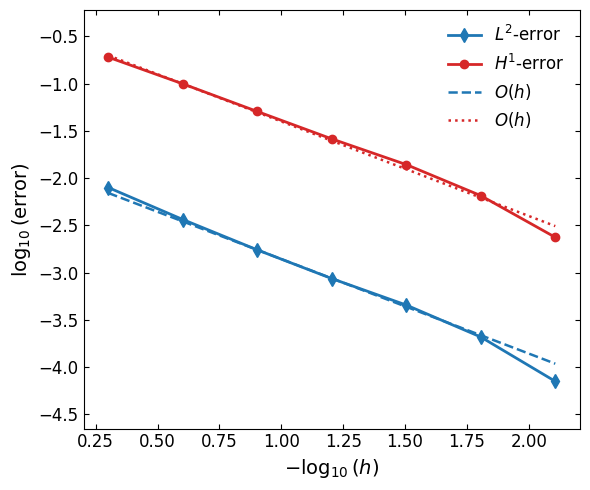

In [5]:
#p_m
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[-N_ref:], dtype=float)
L2_err = np.array(rL2s_fem_list[-N_ref:], dtype=float)
H1_err = np.array(rH1s_list[-N_ref:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.0
x0 = x[2]
y0 = y_L2[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h)$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 1.0
x0 = x[1]
y0 = y_H1[1]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h)$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


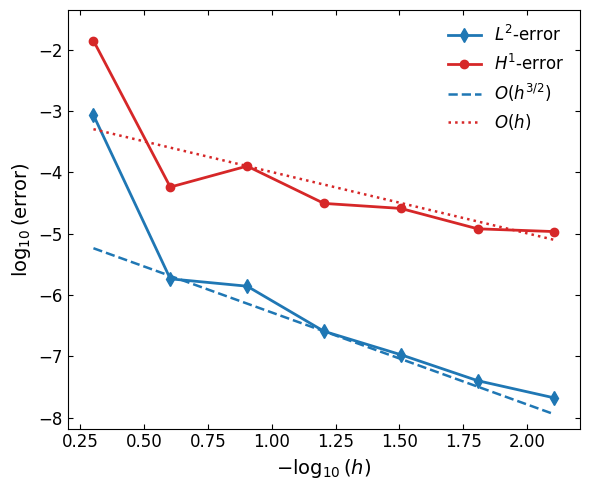

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[-N_ref:], dtype=float)
L2_err = np.array(rL2s_fem_list_pf[-N_ref:], dtype=float)
H1_err = np.array(rH1s_list_pf[-N_ref:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.5
x0 = x[3]
y0 = y_L2[3]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h^{3/2})$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 1
x0 = x[2]
y0 = y_H1[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h)$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


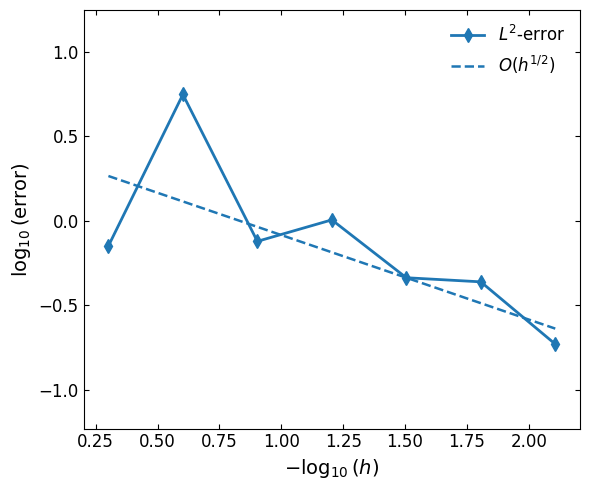

In [7]:
#lmbd
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[-N_ref:], dtype=float)
L2_err = np.array(rL2s_fem_list_lmbd[-N_ref:], dtype=float)*np.sqrt(h)
# H1_err = np.array(rH1s_list_pf[-N_ref:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
# y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

# ax.plot(
#     x, y_H1, "-o",
#     color="tab:red",
#     label=r"$H^1$-error",
#     lw=2,
#     ms=6,
# )

# --- Reference lines ---
# O(h): slope = -1
k_ref = 0.5
x0 = x[4]
y0 = y_L2[4]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h^{1/2})$"
)

# O(h^{1/2}): slope = -1/2
# k_ref = 1
# x0 = x[2]
# y0 = y_H1[2]
# ax.plot(
#     x, y0 - k_ref * (x - x0),
#     ":",
#     lw=1.8,
#     color="tab:red",
#     label=r"$O(h)$"
# )

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(y_L2.min() - 0.5,
            y_L2.max() + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


In [3]:
# jump on Gamma
from dolfinx import geometry
# Given:
# Omega: 3D mesh
# Gamma: 1D mesh
# u: fem.Function on Omega (vector field)
# n_gamma: np.array([nx, ny, nz]) unit vector (same as you already computed)
# Vg: function space on Gamma where you want the jump (same space as lambda, for example)
# n = ufl.FacetNormal(Omega)
# Build vector-valued FE space
Ve = basix.ufl.element("Lagrange",
                       Omega.topology.cell_name(),
                       order,
                       shape=(3,))
V_u = fem.functionspace(Omega, Ve)

u_expr = -k_m * ufl.grad(p_m)                # UFL expression
expr = fem.Expression(u_expr, V_u.element.interpolation_points)
u = fem.Function(V_u, name="u")
u.interpolate(expr) 

dx = x_end - x_start
dy = y_end - y_start

L = np.sqrt(dx**2 + dy**2)   # length of the segment

t = np.array([dx, dy, 0.0]) / L
n_gamma = np.array([-dy, dx, 0.0]) / L  # in-plane normal, z = 0
# m = fem.Constant(Omega, n_gamma)  # m is now the "Gamma-normal" in 3D
m_gamma = fem.Constant(Gamma, n_gamma)

eps = 1e-3  # small offset distance, tuned to your mesh size

# Build a bounding box tree for Omega cells, for point location
bb_tree = geometry.bb_tree(Omega, Omega.topology.dim)

jump_fun = fem.Function(V_l, name="jump_real_on_gamma")

# Coordinates of Gamma dofs
x_g = V_l.tabulate_dof_coordinates().reshape((-1, Gamma.geometry.dim))

# Access to underlying array where we'll store values
jump_vec = jump_fun.x.array
def find_cell(x):
    """
    Find a cell in Omega that contains the point x (3-vector).
    Returns local cell index or None if not found.
    """
    points = np.array([x], dtype=np.float64)          # shape (1, 3)
    candidates = geometry.compute_collisions_points(bb_tree, points)
    cells = geometry.compute_colliding_cells(Omega, candidates, points)
    cell_ids = cells.links(0)                         # cells that contain point 0

    if len(cell_ids) == 0:
        return None
    return int(cell_ids[0])

for i, x_gamma in enumerate(x_g):
    x_gamma = np.asarray(x_gamma, dtype=np.float64)

    x_plus  = x_gamma + eps * n_gamma
    x_minus = x_gamma - eps * n_gamma

    # Find containing cells in Omega
    cell_plus  = find_cell(x_plus)
    cell_minus = find_cell(x_minus)

    if cell_plus is None or cell_minus is None:
        # Near boundary or outside Omega; define jump as 0 or handle specially
        jump_vec[i] = 0.0
        continue

    # Evaluate u at these points
    # u.eval expects x shape (num_points, 3) and cells shape (num_points,)
    x_plus_arr   = np.array([x_plus ], dtype=np.float64)
    x_minus_arr  = np.array([x_minus], dtype=np.float64)
    cells_plus   = np.array([cell_plus ], dtype=np.int32)
    cells_minus  = np.array([cell_minus], dtype=np.int32)

    u_plus_all   = u.eval(x_plus_arr , cells_plus )   # shape (1, 3)
    u_minus_all  = u.eval(x_minus_arr, cells_minus)   # shape (1, 3)

    # Flatten to 1D vectors of length 3
    u_plus_vec   = np.asarray(u_plus_all,  dtype=np.float64).ravel()
    u_minus_vec  = np.asarray(u_minus_all, dtype=np.float64).ravel()
    n_vec        = np.asarray(n_gamma,       dtype=np.float64).ravel()

    # Jump in n_gamma direction
    jump_un = np.dot(u_plus_vec - u_minus_vec, n_vec)
    jump_vec[i] = jump_un

# Push values to PETSc and ghosts (if any)
jump_fun.x.array[:] = jump_vec
jump_fun.x.scatter_forward()


In [4]:
n = ufl.FacetNormal(Omega)
# create DG0 space to store results
W = fem.functionspace(Omega, ("DG", 0))
w = ufl.TestFunction(W)

restriction_test  = Circle(Gamma, 0.0001, degree=q_degree)

# Quadrature space on Γ used to represent the averages
q_el = basix.ufl.quadrature_element(Gamma.basix_cell(), value_shape=(), degree=q_degree)
Rs   = fem.functionspace(Gamma, q_el)
# Average of the DG0 test function on Γ
avg_w = Average(w, restriction_test, Rs)  # Π_R(w) on Γ
# Measures: bulk facets and fracture cells
A_tube = np.pi * R**2
dS_omega = ufl.Measure("dS", domain=Omega)   # interior facets of omega
dS_mm = dS_omega(0)
ds_omega = ufl.Measure("ds", domain=Omega)   # boundary facets of omega
R_form = (
    # ufl.jump(u, n)*ufl.avg(w)*dS_omega
    # ufl.jump(u, n)*ufl.avg(w)*dS_mm
    # + ufl.dot(u, n)*w*ds_omega
    + lmbd * avg_w * ds
    + jump_fun * avg_w * ds
)
# R_form = (
#     ufl.dot(u('+'), n('+')) * w('+') * dS_mm
#   + ufl.dot(u('-'), n('-')) * w('-') * dS_mm
#   + ufl.dot(u, n) * w * ds_omega
#   - lmbd * avg_w * ds
# )
R_form_wo_lmbd = (
    abs(ufl.jump(u, n))*ufl.avg(w)*dS_omega
    # + ufl.dot(u, n)*w*ds_omega
)
from fenicsx_ii import assemble_vector
# R_vec = fem.petsc.assemble_vector(fem.form(R_form))
R_vec = assemble_vector(R_form)
R_vec_wo_lmbd = assemble_vector(R_form_wo_lmbd)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

R_wo_lmbd = fem.Function(W)
R_wo_lmbd.x.array[:] = R_vec_wo_lmbd.array
R_wo_lmbd.x.scatter_forward()

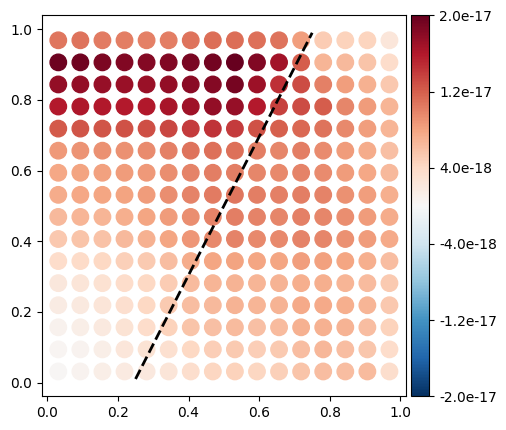

In [5]:
#normal continuity
import matplotlib.pyplot as plt
import numpy as np

# Compute cell centroids
mesh = Omega
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, 0)
cell_to_vertices = mesh.topology.connectivity(tdim, 0)
x = mesh.geometry.x

centroids = np.array([
    x[cell_to_vertices.links(c)].mean(axis=0)
    for c in range(mesh.topology.index_map(tdim).size_local)
])

# Get local residual values (per cell)
R_local = R_wo_lmbd.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c=R_local,
    s=140,
    cmap="RdBu_r",
    vmin=-vmax_abs,
    vmax=vmax_abs
)

ax.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax.set_aspect("equal")
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# --- Colorbar with identical height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(sc, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1e}" for t in ticks])

plt.show()


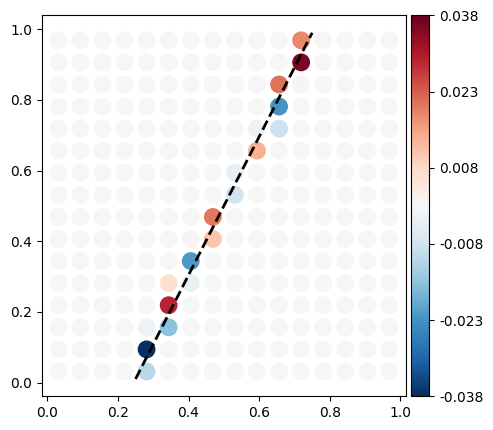

In [6]:
#normal continuity fracture
import matplotlib.pyplot as plt
import numpy as np

# Compute cell centroids
mesh = Omega
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, 0)
cell_to_vertices = mesh.topology.connectivity(tdim, 0)
x = mesh.geometry.x

centroids = np.array([
    x[cell_to_vertices.links(c)].mean(axis=0)
    for c in range(mesh.topology.index_map(tdim).size_local)
])

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c=R_local,
    s=140,
    cmap="RdBu_r",
    vmin=-vmax_abs,
    vmax=vmax_abs
)

ax.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax.set_aspect("equal")
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# --- Colorbar with identical height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(sc, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.show()


In [7]:
-lmbd.x.array

array([ 0.44880497, -0.52583275,  1.34175096, -2.69435321,  4.66511006,
       -6.41855109,  7.12509387, -6.26812099,  4.38480133, -1.94375006,
       -0.05809838,  1.8151219 , -3.48730822,  4.70670504, -5.11956905,
        4.43564432, -2.87015415,  1.3412631 , -0.10446217, -0.94021184,
        1.83500588, -2.5961013 ,  2.76722479, -2.36871411,  1.49528884,
       -0.40454744, -0.88945188,  2.48773602, -4.60497654,  5.97177058,
       -6.28518059,  5.18810532, -3.31236569,  1.17563692,  0.07690748,
       -0.8199764 ,  0.58029674])

In [8]:
jump_fun.x.array

array([-0.02353093, -0.00696693, -0.01225822, -0.01086843, -0.00947865,
       -0.02179715, -0.0199059 , -0.01687043, -0.01463987, -0.01020125,
       -0.00856348, -0.00857661, -0.0068222 , -0.00504786, -0.00568395,
       -0.00497588, -0.00248743, -0.00113815,  0.00170751,  0.00382483,
        0.00446749,  0.00717195,  0.00757668,  0.01273012,  0.01332933,
        0.0172525 ,  0.01702736,  0.02077332,  0.02217595,  0.02202853,
        0.02916516,  0.0255939 ,  0.05902858,  0.06093934,  0.06285009,
        0.06482754,  0.02313038])

In [9]:
# Local conservation
# Discontinuous, piecewise constant space
V0 = fem.functionspace(Omega, ("DG", 0))
v0 = ufl.TestFunction(V0)

# f: source term (e.g. fem.Function or ufl expression)
# local residual R_K = ∫_K (div(q) + f) dx

# residual_form = (ufl.div(u)) * v0 * ufl.dx 
avg_v0 = Average(v0, restriction_test, Rs)  # Π_R(w) on Γ
residual_form_wo_lmbd = (ufl.div(u)) * v0 * ufl.dx #- lmbd * avg_v0 * ds
residual_form = (ufl.div(u)) * v0 * ufl.dx - lmbd * avg_v0 * ds
# L = fem.form(residual_form)

# from dolfinx.fem.petsc import assemble_vector

# R_vec = assemble_vector(L)  # PETSc vector, length = number of cells
from fenicsx_ii import assemble_vector
R_vec = assemble_vector(residual_form)  # PETSc vector, length = number of cells
R_vec_wo_lmbd = assemble_vector(residual_form_wo_lmbd)  # PETSc vector, length = number of cells
# R_vec.ghostUpdate(addv=fem.petsc.InsertMode.ADD, mode=fem.petsc.ScatterMode.REVERSE)

R = fem.Function(V0)
R.x.array[:] = R_vec.array    # copy values into DG0 function

R_wo_lmbd = fem.Function(V0)
R_wo_lmbd.x.array[:] = R_vec_wo_lmbd.array    # copy values into DG0 function


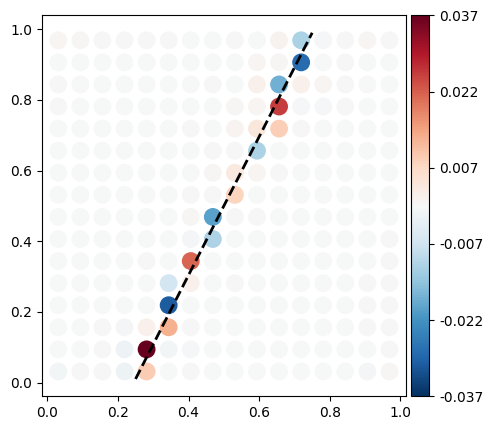

In [10]:
# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c=R_local,
    s=140,
    cmap="RdBu_r",
    vmin=-vmax_abs,
    vmax=vmax_abs
)

ax.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax.set_aspect("equal")
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# --- Colorbar with identical height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(sc, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.show()

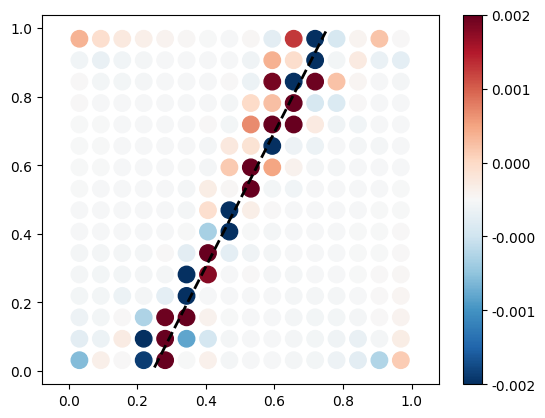

In [11]:
# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
# vmax_abs = np.max([abs(vmin), abs(vmax)])
vmax_abs = 0.002

plt.figure()
sc = plt.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=140, cmap="RdBu_r", vmin=-vmax_abs, vmax=vmax_abs)
plt.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')
# plt.colorbar(sc)
cbar = plt.colorbar(sc)

# 6 ticks between vmin and vmax, including both ends
ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.3f}" for t in ticks])

plt.axis("equal")
# plt.xlabel("x"); plt.ylabel("y")
# plt.title("Local flux balance per element (DG0)")
plt.show()

In [12]:
#local conservation correction
#calc grad p per cell
import numpy as np
from dolfinx import fem, mesh
import ufl

V = V_m
msh = V.mesh

V_g = V_l
g_msh = V_g.mesh
# Your mesh and pressure solution
# msh = mesh_obj
p = p_m

tdim = msh.topology.dim  # should be 3
gdim = msh.geometry.dim  # usually 3 as well

# Vector DG0 space for cell-wise gradients
W = fem.functionspace(msh, ("DG", 0, (gdim,)))

w = ufl.TrialFunction(W)
v = ufl.TestFunction(W)
dx = ufl.dx(domain=msh)

a_grad = ufl.inner(w, v) * dx
L_grad = ufl.inner(ufl.grad(p), v) * dx

grad_p_cell = fem.Function(W)
problem_grad = fem.petsc.LinearProblem(a_grad, L_grad,petsc_options_prefix="grad_p")
grad_p_cell = problem_grad.solve()


In [13]:
# nodal grad (averaging around the node)
msh.topology.create_connectivity(0, tdim)  # vertex -> cell
msh.topology.create_connectivity(tdim, 0)  # cell -> vertex

vertex_to_cell = msh.topology.connectivity(0, tdim)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_vertices = msh.topology.index_map(0).size_local

# Will hold nodal gradients
nodal_grad = np.zeros((num_vertices, gdim), dtype=np.float64)
counts = np.zeros(num_vertices, dtype=np.int32)

W_dofmap = W.dofmap
grad_array = grad_p_cell.x.array

num_cells = msh.topology.index_map(tdim).size_local

for cell in range(num_cells):
    cdofs = W_dofmap.cell_dofs(cell)  # length = gdim
    grad_cell = grad_array[cdofs]     # ∇p in this cell, shape (gdim,)

    cell_vertices = cell_to_vertex.links(cell)
    for vtx in cell_vertices:
        nodal_grad[vtx] += grad_cell
        counts[vtx] += 1

# Final nodal (recovered) gradients
for vtx in range(num_vertices):
    if counts[vtx] > 0:
        nodal_grad[vtx] /= counts[vtx]


In [14]:
#grad in facet
fdim = tdim - 1  # 2 for 3D mesh

# facet <-> cell and facet <-> vertex connectivity
msh.topology.create_connectivity(fdim, tdim)
msh.topology.create_connectivity(fdim, 0)

facet_to_cell = msh.topology.connectivity(fdim, tdim)
facet_to_vertex = msh.topology.connectivity(fdim, 0)

num_facets = msh.topology.index_map(fdim).size_local
x = msh.geometry.x  # vertex coordinates

facet_flux = np.zeros(num_facets, dtype=np.float64)
face_area  = np.zeros(num_facets, dtype=np.float64)
face_norm  = np.zeros((num_facets, gdim), dtype=np.float64)
face_cent  = np.zeros((num_facets, gdim), dtype=np.float64)

def polygon_area_fan(x, vertices):
    """Compute area of a polygonal face by fan triangulation about vertices[0].
       Assumes `vertices` are ordered around the face boundary.
    """
    pts = x[vertices]
    n = len(pts)
    if n < 3:
        return 0.0
    if n == 3:
        return 0.5 * np.linalg.norm(np.cross(pts[1] - pts[0], pts[2] - pts[0]))
    area = 0.0
    v0 = pts[0]
    for i in range(1, n-1):
        area += 0.5 * np.linalg.norm(np.cross(pts[i] - v0, pts[i+1] - v0))
    return area


for f in range(num_facets):
    cells = facet_to_cell.links(f)
    if len(cells) == 0:
        continue

    K_avg = k_values  # constant for now

    vertices = facet_to_vertex.links(f)
    if len(vertices) < 3:
        continue  # degenerate

    # Geometry of face: use first 3 vertices to get normal
    v0, v1, v2 = vertices[:3]
    x0, x1, x2 = x[v0], x[v1], x[v2]

    e1 = x1 - x0
    e2 = x2 - x0

    normal_vec = np.cross(e1, e2)
    norm_n = np.linalg.norm(normal_vec)
    if norm_n == 0.0:
        continue

    area = polygon_area_fan(x,vertices[:4])
    n_hat = normal_vec / norm_n

    # Centroid of face (average all vertex coordinates)
    centroid = np.mean(x[vertices], axis=0)

    # LCG gradient on face: average nodal gradients
    grad_face = np.zeros(gdim, dtype=np.float64)
    for v in vertices:
        grad_face += nodal_grad[v]
    grad_face /= len(vertices)

    # Darcy flux density vector q = -K ∇p / μ
    q_face = -np.dot(K_avg,grad_face)

    # Normal flux density relative to n_hat
    qn_face = np.dot(q_face, n_hat)

    # Total flux through facet (sign w.r.t. n_hat)
    F_face = qn_face * area
    # F_face = qn_face

    facet_flux[f] = F_face
    face_area[f]  = area
    face_norm[f]  = n_hat
    face_cent[f]  = centroid


In [15]:
#cell centroid
msh.topology.create_connectivity(tdim, 0)
cell_to_vertex = msh.topology.connectivity(tdim, 0)

num_cells = msh.topology.index_map(tdim).size_local
cell_cent = np.zeros((num_cells, gdim), dtype=np.float64)

for c in range(num_cells):
    verts = cell_to_vertex.links(c)
    cell_cent[c] = np.mean(x[verts], axis=0)

In [16]:
#calc R manually
tdim = msh.topology.dim
fdim = tdim - 1

# Build connectivities
msh.topology.create_connectivity(tdim, fdim)  # cell -> facet
msh.topology.create_connectivity(fdim, tdim)  # facet -> cell

cell_to_facets = msh.topology.connectivity(tdim, fdim)
facet_to_cells = msh.topology.connectivity(fdim, tdim)

num_cells = msh.topology.index_map(tdim).size_local
R_from_facet = np.zeros(num_cells, dtype=facet_flux.dtype)

from collections import defaultdict

cell_to_xgamma = defaultdict(list)

for i, x_gamma in enumerate(x_g):
    x_gamma = np.asarray(x_gamma, dtype=np.float64)
    cid = find_cell(x_gamma)

    if cid is None:
        continue

    cid = int(cid)
    if 0 <= cid < num_cells:
        cell_to_xgamma[cid].append(i)   # store index of x_gamma

def integrate_lambda_between_nodes(lmbd_values, coords, index1, index3):
    """
    Integrate lambda ds along a 1D manifold between two node indices
    using the trapezoidal rule.

    Parameters
    ----------
    lmbd_values : (N,) array
        Nodal values, e.g. lmbd.x.array
    coords : (N, dim) array
        Coordinates of the nodes in physical space
    index1, index3 : int
        Start and end node indices (inclusive)

    Returns
    -------
    float
        Approximation of ∫ lambda ds between index1 and index3
    """
    i1 = int(index1)
    i3 = int(index3)

    # Build ordered node index list
    if i1 <= i3:
        nodes = np.arange(i1, i3 + 1)
    else:
        nodes = np.arange(i1, i3 - 1, -1)

    # Extract coordinates and values
    pts = coords[nodes]                      # (n_nodes, dim)
    vals = lmbd_values[nodes]               # (n_nodes,)

    # Segment lengths (ds)
    seg_vecs = pts[1:] - pts[:-1]
    seg_lengths = np.linalg.norm(seg_vecs, axis=1)

    # Trapezoidal integration
    integral = np.sum(0.5 * (vals[:-1] + vals[1:]) * seg_lengths)

    return integral

from dolfinx.mesh import meshtags

def integrate_over_cells(lmbd, mesh, dof_indices, cell_id, quad_degree=4):
    """
    Serial-only: integrate the FE function `lmbd` over a single mesh cell `cell_id`
    using the provided list of DOF indices (dof_indices) that belong to that cell.

    Parameters
    ----------
    lmbd : dolfinx.fem.Function or array-like
        The multiplier function (or numpy array of DOF values) defined on the function
        space V_l that lives on `mesh`.
    mesh : dolfinx.mesh.Mesh
        The mesh (Gamma) where the function space lives (serial).
    dof_indices : sequence of int
        Global DOF indices (on serial run these are local indices as well) that belong to `cell_id`.
    cell_id : int
        Global (serial) cell id to integrate over (0 <= cell_id < num_cells).
    quad_degree : int
        Quadrature degree used to assemble the integrals of basis functions over the cell.

    Returns
    -------
    float
        The integral over cell `cell_id` of the FE function represented by `lmbd`.
    """
    # --- Validation & normalization ------------------------------------------------
    dof_indices = np.asarray(dof_indices, dtype=np.int64)
    if dof_indices.size == 0:
        return 0.0

    # Accept lmbd either as a dolfinx Function or an array-like of DOF values
    is_function = isinstance(lmbd, fem.Function)
    if is_function:
        V = lmbd.function_space
        coeffs = lmbd.x.array
    else:
        # lmbd provided as array-like
        coeffs = np.asarray(lmbd, dtype=float)
        # need a function space to assemble test forms; attempt to get it from mesh
        # but we can't, so require the user to pass a Function if not array-like.
        raise TypeError("lmbd must be a dolfinx.fem.Function (serial-only).")

    V = lmbd.function_space  # multiplier space (V_l)

    # cell local range (serial)
    index_map = mesh.topology.index_map(mesh.topology.dim)
    first, last = index_map.local_range  # [first, last)
    if not (first <= cell_id < last):
        raise ValueError(f"cell_id {cell_id} out of local range [{first}, {last}).")

    # check that dof indices are within allowed range
    n_dofs = V.dofmap.index_map.size_local
    if np.any((dof_indices < 0) | (dof_indices >= n_dofs)):
        raise ValueError("Some dof_indices are out of range for the provided function space.")

    # --- Build MeshTags for the single cell (local numbering) -----------------------
    # on serial, local cell id = global cell id, so local = cell_id - first
    local_cell = np.int32(cell_id - first)
    mt = meshtags(mesh, mesh.topology.dim,
                  np.array([local_cell], dtype=np.int32),
                  np.array([1], dtype=np.int32))

    # --- Assemble vector b_j = ∫_{cell} phi_j dx (global vector) --------------------
    # Build a UFL form for TestFunction * 1 over that single-cell tag and assemble vector
    phi = ufl.TestFunction(V)
    one = fem.Constant(mesh, 1.0)
    dx = ufl.Measure("dx", domain=mesh, subdomain_data=mt)
    dx_sel = dx(1, {"quadrature_degree": int(quad_degree)})
    L = phi * one * dx_sel  # L(test) = ∫ phi * 1 dx over the tagged cell

    compiled = fem.form(L)
    b = fem.assemble_vector(compiled)   # dolfinx.la.Vector-like
    print(b)

    # b.x.array contains the local vector entries (serial)
    # b_arr = np.asarray(b.x.array, dtype=float)
    b_arr = b.array

    # --- Dot product: sum_{j in dof_indices} coeffs[j] * b_arr[j] -------------------
    # (Only the DOFs in dof_indices contribute; others have zero local support on cell)
    integral = float(np.dot(coeffs[dof_indices], b_arr[dof_indices]))

    return integral


for c in range(num_cells):
    facets = cell_to_facets.links(c)
    for f in facets:
        cells_f = facet_to_cells.links(f)

        # if len(cells_f) == 1:
        #     # Boundary facet: only one cell, global normal is outward
        #     sign = 1.0
        # else:
        #     # Interior facet: first cell sees +F, second sees -F
        #     sign = 1.0 if c == cells_f[0] else -1.0
        n_hat = face_norm[f]
        A_f   = face_area[f]
        F_face = facet_flux[f]
        face_c = face_cent[f]

        # Decide outward direction for THIS cell
        vec_cf = face_c - cell_cent[c]
        sign_cf = np.sign(np.dot(n_hat, vec_cf))
        if sign_cf == 0:
            continue

        # F_out = sign_cf * F_face   # total flux leaving cell c

        R_from_facet[c] += sign_cf * F_face
    if c in cell_to_xgamma:
        idxs = cell_to_xgamma[c]
        lmbd_int = integrate_lambda_between_nodes(lmbd.x.array, x_g, min(idxs), max(idxs))
        # lmbd_int = integrate_over_cells(lmbd, Gamma, idxs, c, quad_degree=1)
        # lmbd_int = integrate_over_cell_using_dofs(lmbd, Gamma, idxs, c, quad_degree=1)
        # print(idxs)
        # print(lmbd_int)
        R_from_facet[c] -= lmbd_int




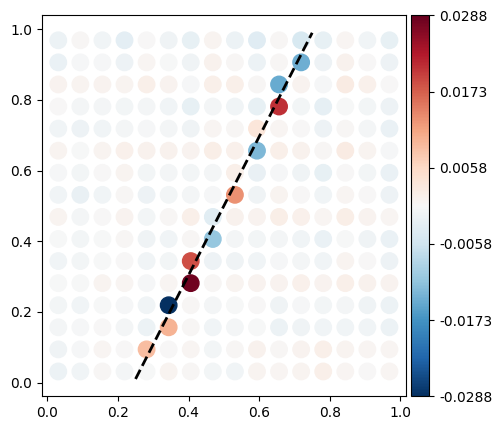

In [17]:
# Get local residual values (per cell)
R_local = R_from_facet
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])

fig, ax = plt.subplots(figsize=(5, 5))

sc = ax.scatter(
    cell_cent[:, 0],
    cell_cent[:, 1],
    c=R_local,
    s=140,
    cmap="RdBu_r",
    vmin=-vmax_abs,
    vmax=vmax_abs
)

ax.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax.set_aspect("equal")
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# --- Colorbar with identical height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(sc, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.4f}" for t in ticks])

plt.show()